In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels import PanelOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px

sns.set_theme()

# Functions

In [3]:
def Pivoting(df): # Function to pivot the dataframe
    df_r = df.pivot(index=['iso3','hdicode','region','year'], columns='indicator_name', values='value').reset_index()
    df_r.reset_index(inplace=True)
    df_r.columns.name = None
    df_r.drop(columns=['index'], inplace=True)
    df_r['year'] = pd.to_datetime(df_r['year'], format='%Y',errors='coerce').dt.year
    return df_r

In [4]:
def calculate_vif(df: pd.DataFrame) -> pd.Series:
    """
    Calculate VIF for each column in df.
    Returns a pd.Series indexed by column names.
    """
    vif = pd.Series(
        [variance_inflation_factor(df.values, i) for i in range(df.shape[1])],
        index=df.columns,
        name="VIF"
    )
    return vif

def vif_selection(
    X: pd.DataFrame,
    thresh: float = 10.0,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Recursively drop the feature with the highest VIF until all VIFs <= thresh.

    Parameters
    ----------
    X : pd.DataFrame
        The design matrix (should be scaled if you want to include intercept)
    thresh : float, default 10.0
        VIF threshold. Variables with VIF > thresh will be removed.
    verbose : bool, default True
        If True, prints each dropped feature and its VIF.

    Returns
    -------
    pd.DataFrame
        Subset of X with all VIFs <= thresh.
    """
    # Work on a copy so we don't modify the original
    X = X.copy()
    # If you’ve already added an intercept column, drop it before VIF calc
    if 'Intercept' in X.columns:
        X = X.drop(columns='Intercept')

    # Calculate current VIFs
    vif = calculate_vif(X)
    max_vif = vif.max()

    # Base case: all VIFs below threshold
    if max_vif <= thresh:
        if verbose:
            print("All VIFs are below threshold.")
        return X

    # Otherwise drop the worst offender and recurse
    worst_feature = vif.idxmax()
    if verbose:
        print(f"Dropping '{worst_feature}' (VIF = {max_vif:.2f})")
    X = X.drop(columns=worst_feature)

    return vif_selection(X, thresh=thresh, verbose=verbose)

In [5]:
def pvalue_selection(
    X: pd.DataFrame,
    y: pd.Series,
    thresh: float = 0.05,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Iteratively drops the predictor with the highest p-value until
    all predictors have p-value <= thresh.

    Parameters
    ----------
    X : pd.DataFrame
        Predictor matrix (not including the constant).
    y : pd.Series
        Response variable.
    thresh : float, default 0.05
        Maximum allowed p-value.
    verbose : bool, default True
        If True, prints each dropped variable and its p-value.

    Returns
    -------
    pd.DataFrame
        Subset of X whose OLS p-values are all <= thresh (plus a constant column).
    """
    X = X.copy()
    # always include constant in the model
    X_const = sm.add_constant(X, has_constant='add')

    while True:
        model = sm.OLS(y, X_const).fit()
        pvals = model.pvalues.drop('const', errors='ignore')  # ignore intercept
        max_p = pvals.max()

        # if the worst p-value is within threshold, we’re done
        if max_p <= thresh:
            if verbose:
                print("All predictors have p-value ≤", thresh)
            break

        # otherwise drop the predictor with the largest p-value
        worst = pvals.idxmax()
        if verbose:
            print(f"Dropping '{worst}' (p = {max_p:.4f})")
        X_const = X_const.drop(columns=[worst])

    return X_const

# Data Loading

In [6]:
path = 'Datasets/'
image_path = '/Users/gianlucafilesi/Library/CloudStorage/OneDrive-EDHEC/04 THESIS/Images/Results/'

gdp_pc_ppp = pd.read_csv(path + 'GDP per capita, PPP (current international)/WB_WDI_NY_GDP_PCAP_PP_CD.csv') # GDP per capita, PPP (current international $)
hdr = pd.read_csv(path + 'HDR/HDR25_Composite_indices_complete_time_series.csv',encoding='latin1') # Human Development Index
hdr_labels = pd.read_excel(path + 'HDR/HDR25_Composite_indices_metadata.xlsx', sheet_name = 'codebook') # Human Development
gs = pd.read_csv(path + 'GenderStatistics/GS.csv') # Globalization data

# Data preparation

In [7]:
GS = gs.copy()
GS = GS.drop(columns=['Unnamed: 0'])
GS = GS.rename(columns={'REF_AREA': 'iso3', 'YEAR': 'year'})

In [8]:
hdr_labels.drop(columns=['Time series'], inplace=True)
hdr_labels.dropna(subset=['Short name'], inplace=True)
hdr_labels.rename(columns={'Full name': 'indicator_name', 'Short name': 'indicator'}, inplace=True)

In [9]:
HDR = hdr.copy()
df_melted = HDR.melt(id_vars=['iso3', 'country', 'hdicode', 'region', 'hdi_rank_2023'], var_name='indicator_year', value_name='value') # Melt the dataframe to long format
df_melted[['indicator', 'year']] = df_melted['indicator_year'].str.extract(r'([a-z0-9_]+)_(\d{4})')
df_final = df_melted[['iso3','hdicode','region','year', 'indicator', 'value']] # Reorder and select final columns
HDR = pd.merge(hdr_labels, df_final, on=['indicator'], how='right') # Merge with labels

In [10]:
HDI_indicators = ['hdi', 'le', 'eys', 'mys', 'gnipc']
GDI_indicators = ['gdi_group', 'gdi', 'hdi_f', 'le_f', 'eys_f', 'mys_f', 'gni_pc_f', 'hdi_m', 'le_m', 'eys_m', 'mys_m', 'gni_pc_m']
IHDI_indicators = ['ihdi', 'coef_ineq', 'loss', 'ineq_le', 'ineq_edu', 'ineq_inc']
GII_indicators = ['gii_rank', 'gii', 'mmr', 'abr', 'se_f', 'se_m', 'pr_f', 'pr_m', 'lfpr_f', 'lfpr_m']
PHDI_indicators = ['rankdiff_hdi_phdi', 'phdi', 'diff_hdi_phdi', 'co2_prod', 'mf']
Population_indicator = ['pop_total']

In [11]:
hdi = HDR[HDR['indicator'].isin(HDI_indicators+Population_indicator)]
gdi = HDR[HDR['indicator'].isin(GDI_indicators+Population_indicator)]
ihdi = HDR[HDR['indicator'].isin(IHDI_indicators+Population_indicator)]
gii = HDR[HDR['indicator'].isin(GII_indicators+Population_indicator)]
phdi = HDR[HDR['indicator'].isin(PHDI_indicators+Population_indicator)]

In [12]:
HDI = Pivoting(hdi)
GDI = Pivoting(gdi)
IHDI = Pivoting(ihdi)
GII = Pivoting(gii)

In [13]:
HDR_idx = {'hdi': 'Human Development Index (value)', 'gii': 'Gender Inequality Index (value)', 
           'gdi': 'Gender Development Index (value)', 'ihdi': 'Inequality-adjusted Human Development Index (value)'}

In [14]:
GDP = gdp_pc_ppp.copy()
GDP = GDP[['REF_AREA_ID','TIME_PERIOD','OBS_VALUE']]
GDP.rename(columns={'REF_AREA_ID':'iso3','TIME_PERIOD':'year','OBS_VALUE':'GDP'},inplace=True)
GDP['year'] = pd.to_datetime(GDP['year'], format='%Y',errors='coerce').dt.year
GDP['logGDP'] = np.log(GDP['GDP'])

# Gap

In [15]:
GII_2023 = GII[GII['year'] == 2023].copy()
GII_2003 = GII[GII['year'] == 2003].copy()
GDP_2023 = GDP[GDP['year'] == 2023].copy()
GDP_2003 = GDP[GDP['year'] == 2003].copy()

In [16]:
Gap_GII = pd.merge(GII_2023[['iso3', 'year', HDR_idx['gii']]], GII_2003[['iso3', 'year', HDR_idx['gii']]], on='iso3', how='inner')
Gap_GDP = pd.merge(GDP_2023[['iso3', 'year', 'logGDP']], GDP_2003[['iso3', 'year', 'logGDP']], on='iso3', how='inner')
GAP_GDP_GII = pd.merge(Gap_GDP, Gap_GII, on=['iso3','year_x','year_y'], how='inner')

In [17]:
GAP_GDP_GII.columns = (
    GAP_GDP_GII.columns
      .str.replace(r'_x$', '_2023', regex=True)
      .str.replace(r'_y$', '_2003', regex=True)
)

In [18]:
GAP_GDP_GII.dropna(inplace=True)
GAP_GDP_GII['diff_logGDP'] = GAP_GDP_GII['logGDP_2023'] - GAP_GDP_GII['logGDP_2003']
GAP_GDP_GII['diff_Gender Inequality Index (value)'] = GAP_GDP_GII[HDR_idx['gii'] + '_2023'] - GAP_GDP_GII[HDR_idx['gii'] + '_2003']

In [19]:
GAP_GDP_GII_GS = pd.merge(GAP_GDP_GII, GS[GS['year']==2023], how='left', on=['iso3'])

# Plot

In [20]:
np.corrcoef(GAP_GDP_GII['diff_logGDP'], GAP_GDP_GII['diff_Gender Inequality Index (value)'])

array([[1.        , 0.11488925],
       [0.11488925, 1.        ]])

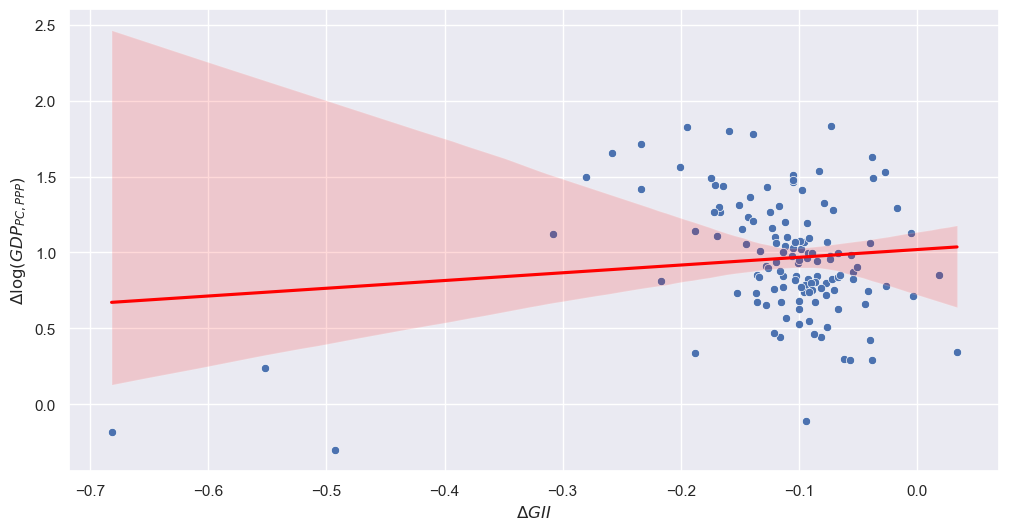

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=GAP_GDP_GII, y='diff_logGDP', x='diff_Gender Inequality Index (value)')
sns.regplot(data=GAP_GDP_GII, y='diff_logGDP', x='diff_Gender Inequality Index (value)', scatter=False, color='red', line_kws={"label": "Trend Line"})
plt.ylabel(r'$\Delta\log (GDP_{PC,PPP})$')
plt.xlabel(r'$\Delta GII$')

plt.savefig(image_path + 'Deltas.pdf', dpi=1500, bbox_inches='tight')
plt.show()

# First regression

## GDP/GII

In [22]:
Panel_GII = GAP_GDP_GII.copy()
Y = Panel_GII['diff_logGDP']
X = Panel_GII['diff_'+HDR_idx['gii']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_logGDP   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.726
Date:                Sat, 17 May 2025   Prob (F-statistic):              0.191
Time:                        11:14:55   Log-Likelihood:                -62.946
No. Observations:                 131   AIC:                             129.9
Df Residuals:                     129   BIC:                             135.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    1.0192      0.057     17.897      0.000       0.907       1.132
diff_Gender Inequality Index (value)     0.5096      0.388      1.314      0.191      -0.258       1.277
==============================================================================
Omnibus:                        0.262   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.877   Jarque-Bera (JB):                0.051
Skew:                           0.018   Prob(JB):                        0.975
Kurtosis:                       3.091   Cond. No.                         11.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## GDP/GII+GS

In [23]:
Panel_GII_GS = GAP_GDP_GII_GS.copy()
Y = Panel_GII_GS['diff_logGDP']
X = Panel_GII_GS
X.drop(columns=['iso3', 'year_2023', 'logGDP_2023', 'year_2003', 'logGDP_2003',
       'Gender Inequality Index (value)_2023',
       'Gender Inequality Index (value)_2003','diff_logGDP','year'],inplace=True)
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_logGDP   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     3.146
Date:                Sat, 17 May 2025   Prob (F-statistic):           6.71e-06
Time:                        11:14:55   Log-Likelihood:                -16.153
No. Observations:                 131   AIC:                             100.3
Df Residuals:                      97   BIC:                             198.1
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
diff_Gender Inequality Index (value)                                                                 -0.0383      0.414     -0.092      0.927      -0.861       0.784
A woman can apply for a passport in the same way as a man (1=yes; 0=no)                               0.1526      0.115      1.323      0.189      -0.076       0.381
A woman can be head of household in the same way as a man (1=yes; 0=no)                              -0.4139      0.195     -2.120      0.037      -0.802      -0.026
A woman can choose where to live in the same way as a man (1=yes; 0=no)                               0.1874      0.147      1.272      0.207      -0.105       0.480
A woman can get a job in the same way as a man (1=yes; 0=no)                                          0.2347      0.277      0.848      0.399      -0.315       0.784
A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no)                      -0.0056      0.131     -0.043      0.966      -0.265       0.254
A woman can open a bank account in the same way as a man (1=yes; 0=no)                               -0.3084      0.442     -0.698      0.487      -1.186       0.569
A woman can register a business in the same way as a man (1=yes; 0=no)                               -0.9040      0.551     -1.641      0.104      -1.998       0.190
A woman can sign a contract in the same way as a man (1=yes; 0=no)                                    1.4070      0.666      2.111      0.037       0.084       2.730
A woman can travel outside her home in the same way as a man (1=yes; 0=no)                            0.4636      0.344      1.346      0.181      -0.220       1.147
A woman can travel outside the country in the same way as a man (1=yes; 0=no)                         0.5638      0.279      2.018      0.046       0.009       1.118
A woman can work at night in the same way as a man (1=yes; 0=no)                                     -0.0177      0.149     -0.119      0.906      -0.313       0.278
A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no)                    -0.0259      0.101     -0.256      0.799      -0.227       0.175
A woman can work in an industrial job in the same way as a man (1=yes; 0=no)                         -0.0136      0.087     -0.157      0.875      -0.185       0.158
A woman has the same rights to remarry as a man (1=yes; 0=no)                                        -0.0541      0.093     -0.581      0.562      -0.239       0.131
Criminal penalties or civil remedies exist for sexual harassment in employment (1=yes; 0=no)   

# Multicollinearity

In [ ]:
S = Panel_GII_GS.iloc[:, 2:].copy()

Sigma = S.corr(method='pearson').abs()
print(Sigma.values.diagonal().sum() == len(S.columns)) # Check if the diagonal is 1
np.fill_diagonal(Sigma.values, np.nan)
Sigma.style.background_gradient(cmap='coolwarm', axis=None)

False


,A woman can be head of household in the same way as a man (1=yes; 0=no),A woman can choose where to live in the same way as a man (1=yes; 0=no),A woman can get a job in the same way as a man (1=yes; 0=no),A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no),A woman can open a bank account in the same way as a man (1=yes; 0=no),A woman can register a business in the same way as a man (1=yes; 0=no),A woman can sign a contract in the same way as a man (1=yes; 0=no),A woman can travel outside her home in the same way as a man (1=yes; 0=no),A woman can travel outside the country in the same way as a man (1=yes; 0=no),A woman can work at night in the same way as a man (1=yes; 0=no),A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no),A woman can work in an industrial job in the same way as a man (1=yes; 0=no),A woman has the same rights to remarry as a man (1=yes; 0=no),Criminal penalties or civil remedies exist for sexual harassment in employment (1=yes; 0=no),Dismissal of pregnant workers is prohibited (1=yes; 0=no),Female and male surviving spouses have equal rights to inherit assets (1=yes; 0=no),Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no),Law prohibits discrimination in employment based on gender (1=yes; 0=no),Men and married women have equal ownership rights to immovable property (1=yes; 0=no),Paid leave is available to fathers (1=yes; 0=no),Paid leave of at least 14 weeks available to mothers (1=yes; 0=no),Sons and daughters have equal rights to inherit assets from their parents (1=yes; 0=no),The age at which men and women can retire with full pension benefits is the same (1=yes; 0=no),The age at which men and women can retire with partial pension benefits is the same (1=yes; 0=no),The government administers 100% of maternity leave benefits (1=yes; 0=no),The law grants spouses equal administrative authority over assets during marriage (1=yes; 0=no),The law prohibits discrimination in access to credit based on gender (1=yes; 0=no),The mandatory retirement age for men and women is the same (1=yes; 0=no),There are periods of absence due to child care accounted for in pension benefits (1=yes; 0=no),There is legislation on sexual harassment in employment (1=yes; 0=no),There is legislation specifically addressing domestic violence (1=yes; 0=no),There is no legal provision that requires a married woman to obey her husband (1=yes; 0=no),There is paid parental leave (1=yes; 0=no)
A woman can be head of household in the same way as a man (1=yes; 0=no),nan,0.366449,0.646075,0.350847,0.392106,0.027851,nan,0.471574,0.489197,0.332222,0.286295,0.140487,0.413418,0.123240,0.285633,0.565253,0.158811,0.147117,0.436761,0.022884,0.140487,0.565253,0.006806,0.150394,0.072087,0.436761,0.217916,0.071619,0.057741,0.147117,0.506661,0.506661,0.199274
A woman can choose where to live in the same way as a man (1=yes; 0=no),0.366449,nan,0.543838,0.374197,0.333817,0.032714,nan,0.586368,0.534058,0.175182,0.260462,0.063049,0.401814,0.064405,0.288043,0.393706,0.013342,0.172805,0.252823,0.024904,0.165018,0.393706,0.073450,0.116390,0.228108,0.252823,0.161244,0.032142,0.080257,0.097347,0.419539,0.595129,0.297818
A woman can get a job in the same way as a man (1=yes; 0=no),0.646075,0.543838,nan,0.447316,0.458436,0.023822,nan,0.686909,0.418416,0.284153,0.373700,0.219160,0.402412,0.105408,0.267346,0.523833,0.135832,0.101410,0.373566,0.030703,0.153160,0.523833,0.005821,0.050620,0.092603,0.373566,0.140403,0.010787,0.065361,0.199092,0.490179,0.717483,0.216861
A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no),0.350847,0.374197,0.447316,nan,0.086947,0.045729,nan,0.489139,0.382067,0.226468,0.273232,0.027046,0.491386,0.138163,0.317330,0.662409,0.122406,0.181277,0.242059,0.210602,0.189940,0.662409,0.063457,0.054383,0.309306,0.242059,0.092986,0.013788,0.062902,0.181277,0.270870,0.551375,0.378105
A woman can open a bank account in the same way

<Figure size 1200x600 with 0 Axes>

In [25]:
S = Panel_GII_GS.iloc[:, 2:].copy()
S.drop(columns=['A woman can sign a contract in the same way as a man (1=yes; 0=no)'],inplace=True)
Sigma = S.corr(method='pearson').abs()
print(Sigma.values.diagonal().sum() == len(S.columns)) # Check if the diagonal is 1
np.fill_diagonal(Sigma.values, np.nan)
Sigma.style.background_gradient(cmap='coolwarm', axis=None)

True


,A woman can be head of household in the same way as a man (1=yes; 0=no),A woman can choose where to live in the same way as a man (1=yes; 0=no),A woman can get a job in the same way as a man (1=yes; 0=no),A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no),A woman can open a bank account in the same way as a man (1=yes; 0=no),A woman can register a business in the same way as a man (1=yes; 0=no),A woman can travel outside her home in the same way as a man (1=yes; 0=no),A woman can travel outside the country in the same way as a man (1=yes; 0=no),A woman can work at night in the same way as a man (1=yes; 0=no),A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no),A woman can work in an industrial job in the same way as a man (1=yes; 0=no),A woman has the same rights to remarry as a man (1=yes; 0=no),Criminal penalties or civil remedies exist for sexual harassment in employment (1=yes; 0=no),Dismissal of pregnant workers is prohibited (1=yes; 0=no),Female and male surviving spouses have equal rights to inherit assets (1=yes; 0=no),Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no),Law prohibits discrimination in employment based on gender (1=yes; 0=no),Men and married women have equal ownership rights to immovable property (1=yes; 0=no),Paid leave is available to fathers (1=yes; 0=no),Paid leave of at least 14 weeks available to mothers (1=yes; 0=no),Sons and daughters have equal rights to inherit assets from their parents (1=yes; 0=no),The age at which men and women can retire with full pension benefits is the same (1=yes; 0=no),The age at which men and women can retire with partial pension benefits is the same (1=yes; 0=no),The government administers 100% of maternity leave benefits (1=yes; 0=no),The law grants spouses equal administrative authority over assets during marriage (1=yes; 0=no),The law prohibits discrimination in access to credit based on gender (1=yes; 0=no),The mandatory retirement age for men and women is the same (1=yes; 0=no),There are periods of absence due to child care accounted for in pension benefits (1=yes; 0=no),There is legislation on sexual harassment in employment (1=yes; 0=no),There is legislation specifically addressing domestic violence (1=yes; 0=no),There is no legal provision that requires a married woman to obey her husband (1=yes; 0=no),There is paid parental leave (1=yes; 0=no)
A woman can be head of household in the same way as a man (1=yes; 0=no),nan,0.366449,0.646075,0.350847,0.392106,0.027851,0.471574,0.489197,0.332222,0.286295,0.140487,0.413418,0.123240,0.285633,0.565253,0.158811,0.147117,0.436761,0.022884,0.140487,0.565253,0.006806,0.150394,0.072087,0.436761,0.217916,0.071619,0.057741,0.147117,0.506661,0.506661,0.199274
A woman can choose where to live in the same way as a man (1=yes; 0=no),0.366449,nan,0.543838,0.374197,0.333817,0.032714,0.586368,0.534058,0.175182,0.260462,0.063049,0.401814,0.064405,0.288043,0.393706,0.013342,0.172805,0.252823,0.024904,0.165018,0.393706,0.073450,0.116390,0.228108,0.252823,0.161244,0.032142,0.080257,0.097347,0.419539,0.595129,0.297818
A woman can get a job in the same way as a man (1=yes; 0=no),0.646075,0.543838,nan,0.447316,0.458436,0.023822,0.686909,0.418416,0.284153,0.373700,0.219160,0.402412,0.105408,0.267346,0.523833,0.135832,0.101410,0.373566,0.030703,0.153160,0.523833,0.005821,0.050620,0.092603,0.373566,0.140403,0.010787,0.065361,0.199092,0.490179,0.717483,0.216861
A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no),0.350847,0.374197,0.447316,nan,0.086947,0.045729,0.489139,0.382067,0.226468,0.273232,0.027046,0.491386,0.138163,0.317330,0.662409,0.122406,0.181277,0.242059,0.210602,0.189940,0.662409,0.063457,0.054383,0.309306,0.242059,0.092986,0.013788,0.062902,0.181277,0.270870,0.551375,0.378105
A woman can open a bank account in the same way as a man (1=yes; 0=no),0.392106,0.333817,0.458436,0.086947,nan,0.010921,0.031755,0

In [26]:
for each in Sigma.columns:
    if Sigma[each].max() > 0.9:
        Sigma.drop(each, axis=1, inplace=True)
features = Sigma.columns
Sigma.style.background_gradient(cmap='coolwarm', axis=None)

,A woman can be head of household in the same way as a man (1=yes; 0=no),A woman can choose where to live in the same way as a man (1=yes; 0=no),A woman can get a job in the same way as a man (1=yes; 0=no),A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no),A woman can open a bank account in the same way as a man (1=yes; 0=no),A woman can register a business in the same way as a man (1=yes; 0=no),A woman can travel outside her home in the same way as a man (1=yes; 0=no),A woman can travel outside the country in the same way as a man (1=yes; 0=no),A woman can work at night in the same way as a man (1=yes; 0=no),A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no),A woman can work in an industrial job in the same way as a man (1=yes; 0=no),A woman has the same rights to remarry as a man (1=yes; 0=no),Criminal penalties or civil remedies exist for sexual harassment in employment (1=yes; 0=no),Dismissal of pregnant workers is prohibited (1=yes; 0=no),Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no),Law prohibits discrimination in employment based on gender (1=yes; 0=no),Paid leave is available to fathers (1=yes; 0=no),Paid leave of at least 14 weeks available to mothers (1=yes; 0=no),The age at which men and women can retire with full pension benefits is the same (1=yes; 0=no),The age at which men and women can retire with partial pension benefits is the same (1=yes; 0=no),The government administers 100% of maternity leave benefits (1=yes; 0=no),The law prohibits discrimination in access to credit based on gender (1=yes; 0=no),The mandatory retirement age for men and women is the same (1=yes; 0=no),There are periods of absence due to child care accounted for in pension benefits (1=yes; 0=no),There is legislation on sexual harassment in employment (1=yes; 0=no),There is legislation specifically addressing domestic violence (1=yes; 0=no),There is no legal provision that requires a married woman to obey her husband (1=yes; 0=no),There is paid parental leave (1=yes; 0=no)
A woman can be head of household in the same way as a man (1=yes; 0=no),nan,0.366449,0.646075,0.350847,0.392106,0.027851,0.471574,0.489197,0.332222,0.286295,0.140487,0.413418,0.123240,0.285633,0.158811,0.147117,0.022884,0.140487,0.006806,0.150394,0.072087,0.217916,0.071619,0.057741,0.147117,0.506661,0.506661,0.199274
A woman can choose where to live in the same way as a man (1=yes; 0=no),0.366449,nan,0.543838,0.374197,0.333817,0.032714,0.586368,0.534058,0.175182,0.260462,0.063049,0.401814,0.064405,0.288043,0.013342,0.172805,0.024904,0.165018,0.073450,0.116390,0.228108,0.161244,0.032142,0.080257,0.097347,0.419539,0.595129,0.297818
A woman can get a job in the same way as a man (1=yes; 0=no),0.646075,0.543838,nan,0.447316,0.458436,0.023822,0.686909,0.418416,0.284153,0.373700,0.219160,0.402412,0.105408,0.267346,0.135832,0.101410,0.030703,0.153160,0.005821,0.050620,0.092603,0.140403,0.010787,0.065361,0.199092,0.490179,0.717483,0.216861
A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no),0.350847,0.374197,0.447316,nan,0.086947,0.045729,0.489139,0.382067,0.226468,0.273232,0.027046,0.491386,0.138163,0.317330,0.122406,0.181277,0.210602,0.189940,0.063457,0.054383,0.309306,0.092986,0.013788,0.062902,0.181277,0.270870,0.551375,0.378105
A woman can open a bank account in the same way as a man (1=yes; 0=no),0.392106,0.333817,0.458436,0.086947,nan,0.010921,0.031755,0.024804,0.033819,0.238814,0.191241,0.184480,0.058970,0.046444,0.020222,0.043072,0.078119,0.081070,0.090069,0.058970,0.028266,0.148686,0.041329,0.088550,0.043072,0.433125,0.035795,0.099417
A woman can register a business in the same way as a man (1=yes; 0=no),0.027851,0.032714,0.023822,0.045729,0.010921,nan,0.022368,0.017471,0.023822,0.045729,0.057104,0.059197,0.041538,0.032714,0.074611,0.030339,0.055026,0.134707,0.063443,0.041538,0.109847,0.073448,0.029111,0.123328,0.030339,0.025214,0.025214,0

# VIF Selection

In [27]:
X_new = vif_selection(Panel_GII_GS[features], thresh=5.0)
X = X_new
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

Dropping 'A woman can open a bank account in the same way as a man (1=yes; 0=no)' (VIF = 126.46)
Dropping 'A woman can travel outside her home in the same way as a man (1=yes; 0=no)' (VIF = 100.27)
Dropping 'A woman can travel outside the country in the same way as a man (1=yes; 0=no)' (VIF = 71.68)
Dropping 'A woman can get a job in the same way as a man (1=yes; 0=no)' (VIF = 48.21)
Dropping 'A woman can register a business in the same way as a man (1=yes; 0=no)' (VIF = 38.25)
Dropping 'There is no legal provision that requires a married woman to obey her husband (1=yes; 0=no)' (VIF = 33.62)
Dropping 'There is legislation on sexual harassment in employment (1=yes; 0=no)' (VIF = 26.68)
Dropping 'There is legislation specifically addressing domestic violence (1=yes; 0=no)' (VIF = 22.77)
Dropping 'A woman can work at night in the same way as a man (1=yes; 0=no)' (VIF = 20.94)
Dropping 'A woman can be head of household in the same way as a man (1=yes; 0=no)' (VIF = 14.72)
Dropping 'Law pr

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_logGDP   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     4.927
Date:                Sat, 17 May 2025   Prob (F-statistic):           5.84e-06
Time:                        11:14:57   Log-Likelihood:                -41.283
No. Observations:                 131   AIC:                             104.6
Df Residuals:                     120   BIC:                             136.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================
                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                              0.9071      0.107      8.460      0.000       0.695       1.119
A woman can work in an industrial job in the same way as a man (1=yes; 0=no)                      -0.0294      0.076     -0.385      0.701      -0.180       0.122
A woman has the same rights to remarry as a man (1=yes; 0=no)                                      0.1797      0.074      2.431      0.017       0.033       0.326
Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no)       -0.0508      0.069     -0.732      0.466      -0.188       0.087
Paid leave is available to fathers (1=yes; 0=no)                                                   0.0594      0.079      0.748      0.456      -0.098       0.217
Paid leave of at least 14 weeks available to mothers (1=yes; 0=no)                                 0.2691      0.080      3.352      0.001       0.110       0.428
The age at which men and women can retire with full pension benefits is the same (1=yes; 0=no)    -0.2325      0.070     -3.335      0.001      -0.371      -0.094
The government administers 100% of maternity leave benefits (1=yes; 0=no)                          0.0184      0.077      0.240      0.811      -0.134       0.171
The law prohibits discrimination in access to credit based on gender (1=yes; 0=no)                 0.0240      0.073      0.329      0.742      -0.120       0.169
There are periods of absence due to child care accounted for in pension benefits (1=yes; 0=no)    -0.1810      0.071     -2.558      0.012      -0.321      -0.041
There is paid parental leave (1=yes; 0=no)                                                        -0.0127      0.084     -0.152      0.880      -0.178       0.153
==============================================================================
Omnibus:                        6.818   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                9.159
Skew:                          -0.261   Prob(JB):                       0.0103
Kurtosis:                       4.186   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# $p$-value selection

In [28]:
X_selected = pvalue_selection(X_new, Y, thresh=0.10)
X = X_selected
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

Dropping 'There is paid parental leave (1=yes; 0=no)' (p = 0.8798)
Dropping 'The government administers 100% of maternity leave benefits (1=yes; 0=no)' (p = 0.8350)
Dropping 'The law prohibits discrimination in access to credit based on gender (1=yes; 0=no)' (p = 0.7727)
Dropping 'A woman can work in an industrial job in the same way as a man (1=yes; 0=no)' (p = 0.7479)
Dropping 'Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no)' (p = 0.4332)
Dropping 'Paid leave is available to fathers (1=yes; 0=no)' (p = 0.5507)
All predictors have p-value ≤ 0.1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_logGDP   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     12.50
Date:                Sat, 17 May 2025   Prob (F-statistic):           1.36e-08
Time:                        11:14:57   Log-Likelihood:                -41.932
No. Observations:                 131   AIC:                             93.86
Df Residuals:                     126   BIC:                             108.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================
                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                              0.9198      0.091     10.105      0.000       0.740       1.100
A woman has the same rights to remarry as a man (1=yes; 0=no)                                      0.1700      0.065      2.627      0.010       0.042       0.298
Paid leave of at least 14 weeks available to mothers (1=yes; 0=no)                                 0.2831      0.069      4.109      0.000       0.147       0.419
The age at which men and women can retire with full pension benefits is the same (1=yes; 0=no)    -0.2326      0.064     -3.620      0.000      -0.360      -0.105
There are periods of absence due to child care accounted for in pension benefits (1=yes; 0=no)    -0.1853      0.065     -2.851      0.005      -0.314      -0.057
==============================================================================
Omnibus:                        6.830   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                9.306
Skew:                          -0.254   Prob(JB):                      0.00953
Kurtosis:                       4.203   Cond. No.                         6.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""